In [8]:
# Data Management/Investigation
import pandas as pd
import numpy as np

# Data Visualization
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# Machine learning methods 
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.tree import DecisionTreeRegressor as DT_reg
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn import tree # For plotting the decision tree rule

# For model interpretation
from sklearn.inspection import (
    permutation_importance,
    partial_dependence, 
    PartialDependenceDisplay, 
    plot_partial_dependence
)

# Misc
import warnings
warnings.filterwarnings("ignore")


In [15]:
# Read
df = pd.read_csv("../07_data_staged/clean_data.csv")
# Drop
df = df.drop(columns=["Week","Season","Team_A","Team_B","Game_pts_diff","Game_yards_diff","Game_TO","Game_yds"])
# Convert
for col in ['Division_Rival','Conference_Rival', 'Grass', 'Home','Same_surface','Win']:
    df[col] = df[col].astype('category')

# Train-test split

In [16]:
# Train test split
y = df[['Win','id']]
X = df.drop(columns=["Win",'id'])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=42)

In [17]:
train_id = train_y['id']
test_id = test_y['id']

train_y = train_y['Win']
test_y = test_y['Win']

# Train model

## Cross validation

In [21]:
# Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=10, shuffle=True,random_state=1234)

### Initialize pipeline

Note that we still want to scale values, but we want to do this in the pipeline since it utilizes information we'll only learn from the training data (i.e. min/max, mean, std, etc.)


In [22]:
pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])

### Select Models & Tuning Parameters


In [23]:
search_space = [
    
    # NaiveBayes
    {'model': [NB()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[5,10,25,50]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DT()],
     'model__max_depth':[2,3,4]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
    'model__max_depth':[2,3,4],
    'model__n_estimators':[500,1000,1500]}   
]

# Alternative method

In [32]:
# from sklearn.neural_network import MLPClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
# from sklearn.gaussian_process import GaussianProcessClassifier
# from sklearn.gaussian_process.kernels import RBF
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

# search_space = [
#     {'model': [MLPClassifier()]},    
#     {'model' : [KNeighborsClassifier()]},
#     {'model': [SVC()]},
#     {'model' : [GaussianProcessClassifier()]},
#     {'model': [RBF()]},
#     {'model' : [DecisionTreeClassifier()]},
#     {'model': [GaussianNB()]},
#     {'model' : [QuadraticDiscriminantAnalysis()]},
#     {'model' : [RandomForestClassifier()]},
#     {'model': [AdaBoostClassifier()]},
#     {'model' : [GradientBoostingClassifier()]},    
# ]

### Run models in a GridSearch

In [25]:
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='roc_auc',
                      n_jobs=-1, verbose = 2 )
search.fit(train_X,train_y)

Fitting 10 folds for each of 17 candidates, totalling 170 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=-1,
             param_grid=[{'model': [GaussianNB()]},
                         {'model': [KNeighborsClassifier()],
                          'model__n_neighbors': [5, 10, 25, 50]},
                         {'model': [DecisionTreeClassifier()],
                          'model__max_depth': [2, 3, 4]},
                         {'model': [RandomForestClassifier(max_depth=4,
                                                           n_estimators=500)],
                          'model__max_depth': [2, 3, 4],
                          'model__n_estimators': [500, 1000, 1500]}],
             scoring='roc_auc', verbose=2)

# Performance metrics

In [26]:
# Best score
search.best_score_

0.7165152524782502

In [27]:
# Best parameter
search.best_params_

{'model': RandomForestClassifier(max_depth=4, n_estimators=500),
 'model__max_depth': 4,
 'model__n_estimators': 500}

In [28]:
# Select model
model = search.best_estimator_

### Performance on training data

In [29]:
# ROC AUC score on training data
m.roc_auc_score(train_y,model.predict_proba(train_X)[:,1])

0.7295065364911864

In [30]:
# Accuracy score on training data
m.accuracy_score(train_y,model.predict(train_X))

0.663798049340218

# Model interpretability

In [31]:
vi = permutation_importance(model,train_X,train_y,n_repeats=5)

In [32]:


# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,Season_SRS,0.048575,0.002294,0.043987,0.053163
1,Season_offense,0.009313,0.003013,0.003287,0.015340
2,Miles_traveled,0.006942,0.001485,0.003973,0.009911
3,Home,0.004628,0.001309,0.002010,0.007246
4,Season_SoS,0.003175,0.001791,-0.000408,0.006757
5,Attendance_pct,0.002065,0.000835,0.000396,0.003735
6,Attendance,0.001186,0.000508,0.000169,0.002202
7,Time_diff,0.001167,0.001048,-0.000930,0.003263
8,Season_defense,0.000956,0.000676,-0.000396,0.002308
9,Same_surface,0.000708,0.000560,-0.000411,0.001827


# ROC Curve on training data

First, we need the model to return **probabilities** not predictions.

In [42]:
probs = model.predict_proba(train_X)
probs =  pd.DataFrame(probs,columns=model.classes_)
probs.head()

,0,1
0,0.689881,0.310119
1,0.537375,0.462625
2,0.374010,0.625990
3,0.366869,0.633131
4,0.275863,0.724137


In [43]:
# Generate the False Positive Rate and True Positive Rate Given different thresholds
fpr, tpr, thresholds = m.roc_curve(train_y, probs[1])

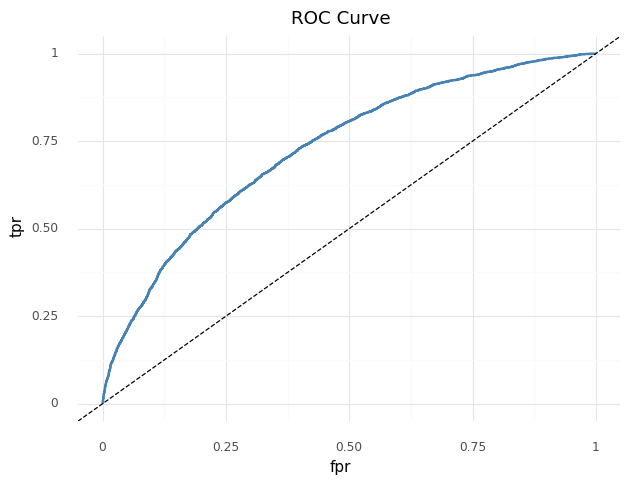

<ggplot: (351917472)>

In [44]:
# Plot the ROC Curve
( 
    ggplot(pd.DataFrame(dict(fpr=fpr,tpr=tpr)),
           aes(x="fpr",y="tpr")) +
    geom_path(color="steelblue",size=1) +
    geom_abline(intercept=0,slope=1,linetype="dashed") +
    theme_minimal() +
    labs(title="ROC Curve") +
    theme(figure_size=(7,5))
)

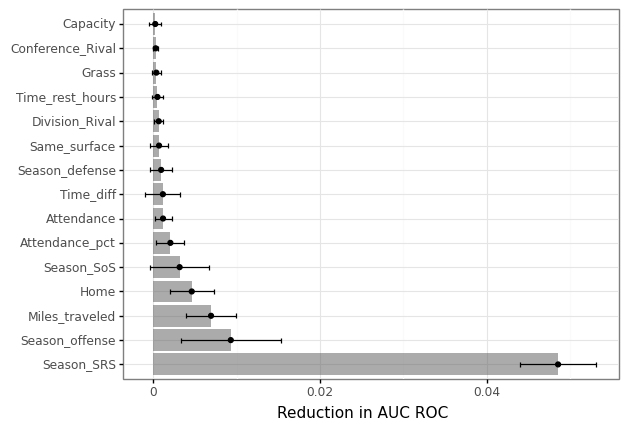

<ggplot: (274540623)>

In [33]:
# Plot
(
    ggplot(vi_dat,
          aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)


# Predict & Output

In [34]:
y_pred = model.predict(test_X)

[CV] END .................................model=GaussianNB(); total time=   0.0s
[CV] END .model=KNeighborsClassifier(), model__n_neighbors=5; total time=   0.0s
[CV] END .model=KNeighborsClassifier(), model__n_neighbors=5; total time=   0.0s
[CV] END model=KNeighborsClassifier(), model__n_neighbors=10; total time=   0.0s
[CV] END model=KNeighborsClassifier(), model__n_neighbors=25; total time=   0.0s
[CV] END model=KNeighborsClassifier(), model__n_neighbors=50; total time=   0.0s
[CV] END .model=DecisionTreeClassifier(), model__max_depth=2; total time=   0.0s
[CV] END .model=DecisionTreeClassifier(), model__max_depth=2; total time=   0.0s
[CV] END .model=DecisionTreeClassifier(), model__max_depth=4; total time=   0.0s
[CV] END .model=DecisionTreeClassifier(), model__max_depth=4; total time=   0.0s
[CV] END model=RandomForestClassifier(), model__max_depth=2, model__n_estimators=1000; total time=   2.6s
[CV] END model=RandomForestClassifier(), model__max_depth=2, model__n_estimators=100

[CV] END .................................model=GaussianNB(); total time=   0.0s
[CV] END .model=KNeighborsClassifier(), model__n_neighbors=5; total time=   0.0s
[CV] END model=KNeighborsClassifier(), model__n_neighbors=10; total time=   0.0s
[CV] END model=KNeighborsClassifier(), model__n_neighbors=25; total time=   0.0s
[CV] END model=KNeighborsClassifier(), model__n_neighbors=50; total time=   0.0s
[CV] END .model=DecisionTreeClassifier(), model__max_depth=3; total time=   0.0s
[CV] END .model=DecisionTreeClassifier(), model__max_depth=3; total time=   0.0s
[CV] END model=RandomForestClassifier(), model__max_depth=2, model__n_estimators=500; total time=   1.3s
[CV] END model=RandomForestClassifier(), model__max_depth=2, model__n_estimators=500; total time=   1.3s
[CV] END model=RandomForestClassifier(), model__max_depth=3, model__n_estimators=500; total time=   1.6s
[CV] END model=RandomForestClassifier(), model__max_depth=3, model__n_estimators=500; total time=   1.6s
[CV] END mode

[CV] END .................................model=GaussianNB(); total time=   0.0s
[CV] END .model=KNeighborsClassifier(), model__n_neighbors=5; total time=   0.0s
[CV] END model=KNeighborsClassifier(), model__n_neighbors=10; total time=   0.0s
[CV] END model=KNeighborsClassifier(), model__n_neighbors=25; total time=   0.0s
[CV] END model=KNeighborsClassifier(), model__n_neighbors=50; total time=   0.0s
[CV] END .model=DecisionTreeClassifier(), model__max_depth=2; total time=   0.0s
[CV] END .model=DecisionTreeClassifier(), model__max_depth=2; total time=   0.0s
[CV] END .model=DecisionTreeClassifier(), model__max_depth=4; total time=   0.0s
[CV] END .model=DecisionTreeClassifier(), model__max_depth=4; total time=   0.0s
[CV] END model=RandomForestClassifier(), model__max_depth=2, model__n_estimators=1500; total time=   3.9s
[CV] END model=RandomForestClassifier(), model__max_depth=2, model__n_estimators=1500; total time=   4.0s
[CV] END model=RandomForestClassifier(), model__max_depth=2

In [36]:
d = {'id': test_id,'prediction':y_pred}


In [39]:
submission = pd.DataFrame(d)
submission.head()

,id,prediction
8539,8913,0
3585,3739,1
13200,13772,1
5715,5957,1
7592,7922,0


In [41]:
submission.to_csv("../07_data_staged/submission.csv", index=False)

# Performance metrics on test set

In [43]:
# Accuracy score on test set
m.accuracy_score(test_y,y_pred)

0.6448651749856569

In [44]:
# ROC AUC score
m.roc_auc_score(test_y,y_pred)

0.6452252273015361